In [6]:
import warnings

warnings.simplefilter("ignore")

In [7]:
import cv2 
import tensorflow as tf 
import os
from matplotlib import pyplot as plt 
import numpy as np 

In [2]:
mainDirectory = "C:/Users/laksh/Downloads/Tumour_All_Sides_v2[1]/Tumour All Sides v2"

In [4]:
imageHeight = 256
imageWidth = 256

tumourCategories = ["Sagittal", "Axial", "Coronal"] 

SagittalData = []
AxialData = []
CoronalData = []

for classess in tumourCategories:
    pathDirectory = os.path.join(mainDirectory, classess)
    for image in os.listdir(path=pathDirectory):
       # Taking images of all image directories
       image_array = cv2.imread(os.path.join(pathDirectory, image))
       image_array = cv2.resize(image_array, (imageHeight, imageWidth))
       if classess == "Sagittal":
         SagittalData.append(image_array)
       elif classess == "Axial":
         AxialData.append(image_array)
       elif classess == "Coronal":
         CoronalData.append(image_array)


SagittalData = np.array(SagittalData)
AxialData = np.array(AxialData)
CoronalData = np.array(CoronalData)

In [9]:
from keras.preprocessing.image import ImageDataGenerator 
generatedData = ImageDataGenerator(
    rotation_range = 8, #rotate image to 45 degrees
    zoom_range = 0.05, # zoom image from 0.15 in and out
    horizontal_flip= True, # flip image horizontally
    fill_mode= "constant", # gap filler after augmentation with the nearest pixel value
    shear_range= 0.05,
    cval=0 # fills black around the image
) 

def augementData(image_dataset_type, path, prefix, val):
    for x in image_dataset_type:
        x = x.reshape(1, 256, 256, 3)
        count = 0
        for batches in generatedData.flow(x, 
                                      batch_size=16, 
                                      save_to_dir=path,
                                      save_prefix=prefix,
                                      save_format="jpg"):
            count += 1
            if count > val:
                break

In [18]:
augementData(AxialData, "C:/Users/laksh/Downloads/Tumour_All_Sides_v2[1]/Tumour All Sides v2/AugmentedAxial", "aug_axial", 3)
augementData(SagittalData, "C:/Users/laksh/Downloads/Tumour_All_Sides_v2[1]/Tumour All Sides v2/AugmentedSagittal/", "aug_sagittal", 6)
augementData(CoronalData, "C:/Users/laksh/Downloads/Tumour_All_Sides_v2[1]/Tumour All Sides v2/AugmentedCoronal", "aug_coronal", 6)

In [12]:
CoronalData.shape

(1678, 256, 256, 3)

In [36]:
imageHeight = 256
imageWidth = 256

tumourCategories = ["AugmentedSagittal", "AugmentedAxial", "AugmentedCoronal"] 

SagittalData = []
AxialData = []
CoronalData = []

for classess in tumourCategories:
    pathDirectory = os.path.join(mainDirectory, classess)
    for image in os.listdir(path=pathDirectory):
       # Taking images of all image directories
       image_array = cv2.imread(os.path.join(pathDirectory, image))
       image_array = cv2.resize(image_array, (imageHeight, imageWidth))
       if classess == "AugmentedSagittal":
         SagittalData.append(image_array)
       elif classess == "AugmentedAxial":
         AxialData.append(image_array)
       elif classess == "AugmentedCoronal":
         CoronalData.append(image_array)


SagittalData = np.array(SagittalData)
AxialData = np.array(AxialData)
CoronalData = np.array(CoronalData)

In [37]:
# Define the gamma value
gamma = 1.5

# Function to apply gamma correction
def applyGammaCorrection(images, gamma):
    for index in range(0, len(images)):
          # Normalize pixel values to the range [0, 1]
          normalized_image = images[index] / 255.0
    
          # Apply gamma correction
          corrected_image = np.power(normalized_image, gamma)
    
          # Denormalize the image to the original range [0, 255]
          corrected_image = (corrected_image * 255).astype(np.uint8)
    
          images[index] = corrected_image
      
    

# Apply gamma correction to gliomaData
applyGammaCorrection(SagittalData, gamma)
applyGammaCorrection(AxialData, gamma)
applyGammaCorrection(CoronalData, gamma)

In [38]:
import gc  #delete garbage otherwise there is a memory issue
gc.collect()
# Types of the tumours and its directory name
tumourCategories = ["Sagittal", "Axial", "Coronal"]

# Combine image data and labels
allImages = np.concatenate([SagittalData, AxialData, CoronalData], axis=0)

# Create corresponding labels based on the class names
allLabels = np.concatenate([
    np.full(len(SagittalData), "Sagittal"),   
    np.full(len(AxialData), "Axial"), 
    np.full(len(CoronalData), "Coronal"),   
], axis=0)

In [39]:
allImages.shape

(21785, 256, 256, 3)

In [40]:
import gc 
gc.collect()

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(allImages, allLabels, test_size=0.3, random_state=4) 

In [41]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((15249, 256, 256, 3), (6536, 256, 256, 3), (15249,), (6536,))

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Use fit_transform on the training set
labelEncoder = LabelEncoder()
train_y_encoded = labelEncoder.fit_transform(train_y)

# Use transform on the test set
test_y_encoded = labelEncoder.transform(test_y)

# Main directory to store training and testing data
mainDataDirectory = "C:/Users/laksh/Downloads/Tumour_All_Sides_v2[1]/Final"

# Making two directories for both training and testing data sets
trainDirectory = os.path.join(mainDataDirectory, 'Train')
testDirectory = os.path.join(mainDataDirectory, 'Test')

# Categories of tumour classification
tumourCategories = ["Axial", "Coronal" ,"Sagittal"]

# Creating the subdirectories by checking whether they already exist
for category in tumourCategories:
    os.makedirs(os.path.join(trainDirectory, category), exist_ok=True)
    os.makedirs(os.path.join(testDirectory, category), exist_ok=True)

# Save training images
for i in range(len(train_x)):
    category = tumourCategories[int(train_y_encoded[i])]
    filename = f"{category}_train_{i}.jpg"
    filepath = os.path.join(trainDirectory, category, filename)
    cv2.imwrite(filepath, train_x[i])

In [ ]:
# Save testing images
for i in range(len(test_x)):
    category = tumourCategories[int(test_y_encoded[i])]
    filename = f"{category}_test_{i}.jpg"
    filepath = os.path.join(testDirectory, category, filename)
    cv2.imwrite(filepath, test_x[i])

In [18]:
import gc

tumourCategories = ["Axial", "Coronal" ,"Sagittal"]
# Main directory where data is saved
mainDataDirectory = "C:/Users/laksh/Downloads/Tumour_All_Sides_v2[1]/Final"

# Directories for training and testing data
trainDirectory = os.path.join(mainDataDirectory, 'Train')
testDirectory = os.path.join(mainDataDirectory, 'Test')

# Function to read images from a directory
def read_images_from_directory(directory):
    images = []
    labels = []
    for category in tumourCategories:
        category_path = os.path.join(directory, category)
        label = tumourCategories.index(category)
        for filename in os.listdir(category_path):
            image_path = os.path.join(category_path, filename)
            image = cv2.imread(image_path)
            
            images.append(image)
            if label == 0:
                labels.append("Axial")
            elif label == 1:
                labels.append("Coronal")
            elif label == 2:
                labels.append("Sagittal")
    return images, labels

In [19]:
# Read training images
train_x, train_y = read_images_from_directory(trainDirectory)

# Read testing images
test_x, test_y = read_images_from_directory(testDirectory)

# Convert the lists to numpy arrays
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [20]:
train_y.shape, train_x.shape, test_x.shape, test_y.shape

((15249,), (15249, 256, 256, 3), (6536, 256, 256, 3), (6536,))

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Map string labels to integer labels
label_mapping = {'Axial': 0, 'Coronal': 1, 'Sagittal': 2}

# Convert string labels to integer labels
train_y = [label_mapping[label] for label in train_y]
test_y = [label_mapping[label] for label in test_y]

# Convert labels to one-hot encoded format
train_y_one_hot = to_categorical(train_y, num_classes=3) 
test_y_one_hot = to_categorical(test_y, num_classes=3)

In [53]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_x, train_y_one_hot, epochs=5, batch_size=16, validation_data=(test_x, test_y_one_hot))

Epoch 1/5
954/954 [==============================] - 4519s 5s/step - loss: 1.2897 - accuracy: 0.9529 - val_loss: 0.1940 - val_accuracy: 0.9816
Epoch 2/5
954/954 [==============================] - 4375s 5s/step - loss: 0.1912 - accuracy: 0.9659 - val_loss: 0.1486 - val_accuracy: 0.9847
Epoch 3/5
954/954 [==============================] - 4373s 5s/step - loss: 0.1411 - accuracy: 0.9663 - val_loss: 0.1154 - val_accuracy: 0.9847
Epoch 4/5
954/954 [==============================] - 4410s 5s/step - loss: 0.1353 - accuracy: 0.9669 - val_loss: 0.1798 - val_accuracy: 0.9855
Epoch 5/5
954/954 [==============================] - 4406s 5s/step - loss: 0.1332 - accuracy: 0.9658 - val_loss: 0.1253 - val_accuracy: 0.9792


In [55]:
# Save the model if needed
model.save('brain_side_vgg16.h5')

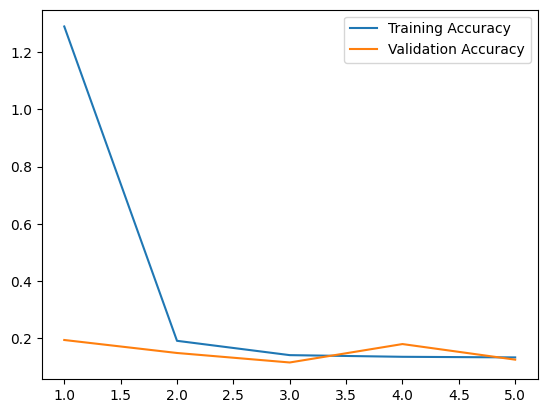

In [69]:
epochs = np.array([x for x in range(1, 6, 1)])
plt.plot(epochs, history.history["loss"], label="Training Loss")
plt.plot(epochs, history.history["val_loss"], label="Validation Loss")
plt.legend()

In [28]:
from keras.models import load_model

# Load the model
model = load_model('brain_side_vgg16.h5')

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 23104580 (88.14 MB)
Trainable params: 8389892 (32.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Assuming you have the following variables defined: test_x, test_y_one_hot
# Map string labels to integer labels
label_mapping = {'Axial': 0, 'Coronal': 1, 'Sagittal': 3}

# Make predictions on the test set
predictions = model.predict(test_x)
predicted_classes = np.argmax(predictions, axis=1)

205/205 [==============================] - 1197s 6s/step


In [33]:
# Convert one-hot encoded test labels back to integers
true_classes = test_y

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm

array([[2326,    5,   14],
       [  42, 1969,   52],
       [  12,   11, 2105]], dtype=int64)

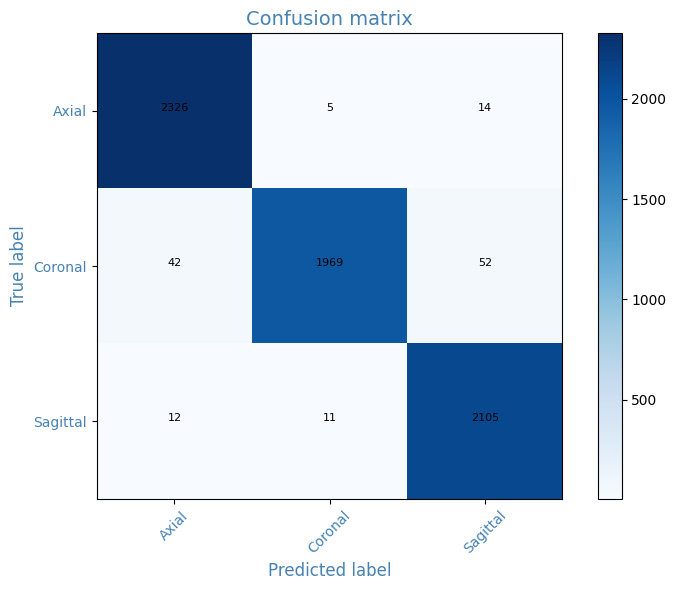

In [72]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):

    title = 'Confusion matrix'
    if normalize:
        y_true = y_true.astype('float') / y_true.sum(axis=0, keepdims=True)
        title = 'Normalized confusion matrix'
    
    # Define custom colors for the plot
    blue, green = "#4682B4", "#008000"
    
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    plt.imshow(confusion_matrix(y_true, y_pred), interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14, color=blue)  # Adjust title fontsize and color
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10, color=blue)  # Use blue for the ticks
    plt.yticks(tick_marks, classes, fontsize=10, color=blue)  # Use blue for the ticks

    fmt = '.2f' if normalize else 'd'
    thresh = y_true.max() / 2.
    for i, j in itertools.product(range(len(classes)), range(len(classes))):
        plt.text(j, i, format(y_true[i] if normalize else cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if y_true[i] > thresh else "black", fontsize=8)

    plt.ylabel('True label', fontsize=12, color=blue)  # Use blue for the labels
    plt.xlabel('Predicted label', fontsize=12, color=blue)  # Use blue for the labels
    plt.tight_layout()

# Plot non-normalized confusion matrix with a blue and green theme (Blues)
plot_confusion_matrix(true_classes, predicted_classes, classes=label_mapping.keys(), normalize=False, cmap=plt.cm.Blues)

plt.show()

In [34]:
from sklearn.metrics import classification_report
import pandas as pd

disease = {0:'Axial', 1:'Coronal', 3:'Sagittal'}


# Mapping actual and predicted classes to disease names
actual_classes = [disease[x] for x in true_classes]
predict_classes = [disease[x] for x in predicted_classes]

# Generate classification report
report = classification_report(actual_classes, predict_classes, output_dict=True)

# Convert classification report to DataFrame
classification_df = pd.DataFrame(report)

classification_df

,Axial,Coronal,Sagittal,accuracy,macro avg,weighted avg
precision,0.977311,0.991940,0.969599,0.979192,0.979617,0.979417
recall,0.991898,0.954435,0.989192,0.979192,0.978508,0.979192
f1-score,0.984550,0.972826,0.979298,0.979192,0.978891,0.979139
support,2345.000000,2063.000000,2128.000000,0.979192,6536.000000,6536.000000


In [36]:
print(classification_df)

                 Axial      Coronal     Sagittal  accuracy    macro avg  \
precision     0.977311     0.991940     0.969599  0.979192     0.979617   
recall        0.991898     0.954435     0.989192  0.979192     0.978508   
f1-score      0.984550     0.972826     0.979298  0.979192     0.978891   
support    2345.000000  2063.000000  2128.000000  0.979192  6536.000000   

           weighted avg  
precision      0.979417  
recall         0.979192  
f1-score       0.979139  
support     6536.000000  


In [77]:
import numpy as np

label_mapping = {0:'Axial', 1:'Coronal', 3:'Sagittal'}
image = np.expand_dims(train_x[850], axis=0) 
class_name = np.argmax(model.predict(image))
class_name

1/1 [==============================] - 0s 298ms/step


0

Text(0.5, 1.0, 'Axial')

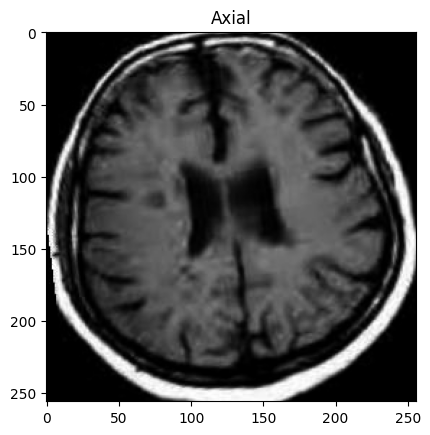

In [93]:
plt.imshow(train_x[4500])
plt.title(label_mapping[train_y[4500]])